### Read some audio file and graph it


In [81]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile as wavfile



In [82]:
# rate, data = wavfile.read('/Users/lkang/psrc/pcm/hz377.wav')
# rate, data = wavfile.read('/Users/lkang/psrc/pcm/doorbell-1.wav')
# rate, data = wavfile.read('/Users/lkang/Downloads/Cisco.wav')
rate, data = wavfile.read('/Users/lkang/Downloads/gangsta.wav') #youtube coolio gangsta paradise 54 seconds in
data_length = len(data)
print(data_length)

11243567


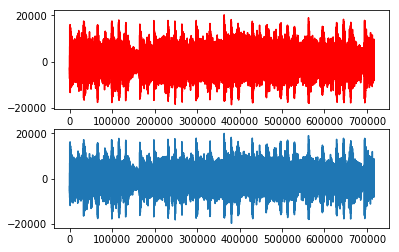

In [83]:
# Skip the song intro
data_start = int(3*data_length/4)
# A 1024 sample could be a beat. 
beat_sample_size = 1024
# ambient energy is calculated from 1 second of the song
ambient_data_size = 44*beat_sample_size
# lets check this beat samples
samples = 700

#lets see some random audio data in the song... 
plt.subplot(2,1,1)
plt.plot(data[data_start:(data_start + samples*beat_sample_size),0], 'r')
plt.subplot(2,1,2)
plt.plot(data[data_start:data_start + samples*beat_sample_size,1])
plt.show()


In [84]:
# data is read in as int. need to convert integer data to float data
data = data.astype('float')

idata = data[:,0] + 1j * data[:,1]
#print(idata)


In [85]:
# calculate sum of squares of an array. 
# data - typically 1024 samples
def total_energy(data):
    abs = np.absolute(data)
    sq = np.square(abs)
    sum_sq = np.sum(sq)
    return sum_sq

# calculate the ambient energy of an array
#  energy_array - 44 
def ambient_energy(energy_array):
    ae = np.mean(energy_array)
    return ae

# calculate the energy ratio of a sample given the last N energy samples
#  sample_energy - the current sample
#  energy_array - the previous samples
def energy_ratio(sample_energy, energy_array):
    last_axis = energy_array.ndim - 1
    ambient = np.mean(energy_array, axis=last_axis)
    ratio = sample_energy/ambient
#     print('ratio = sample_energy / ambient')
#     print("{ratio} = {sample_energy} / {ambient}".format(ratio=ratio, sample_energy=sample_energy, ambient=ambient))
    return ratio



http://www.flipcode.com/misc/BeatDetectionAlgorithms.pdf

Implement the simple energy calculator by first calculating the ambient energy.

ambient_energy = total sum of squares from a 44 blocks (1 second), then find the average per block


In [86]:
# A 1024 sample could be a beat. Test calculation of the energy
beat_energy = total_energy(data[data_start:(data_start+beat_sample_size), 0])
print(beat_energy)

# imaginary
# beat_energy = total_energy(idata[data_start:(data_start+beat_sample_size)])
# print(beat_energy)
# (-6295548739+9158860698j)  #this looks negative...

ambient_array = np.ones(44)
ambient_array = np.full(44, beat_energy)
print(ambient_array)

33266394961.0
[  3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10
   3.32663950e+10   3.32663950e+10   3.32663950e+10   3.32663950e+10]


In [87]:
beats = np.ndarray(0)
for sample in range(samples):
    sample_start = data_start + sample * beat_sample_size
    beat_energy = total_energy(data[sample_start:(sample_start+beat_sample_size), 0])
    beat_ratio = energy_ratio(beat_energy, ambient_array)
    beats = np.append(beats, beat_ratio)
    ambient_array = np.append(ambient_array[1:], beat_energy)
#     print(ambient_array)
    

ratio = sample_energy / ambient
1.0 = 33266394961.0 / 33266394961.0
ratio = sample_energy / ambient
0.6635535376730357 = 22074034062.0 / 33266394961.0
ratio = sample_energy / ambient
0.699497031835677 = 23091812189.0 / 33012023122.386364
ratio = sample_energy / ambient
0.4673165056083122 = 15319000778.0 / 32780782604.840908
ratio = sample_energy / ambient
0.42868592905835756 = 13877801261.0 / 32372887282.5
ratio = sample_energy / ambient
0.4820055200585857 = 15391514707.0 / 31932237425.68182
ratio = sample_energy / ambient
0.4371754707355968 = 13782389583.0 / 31525990147.18182
ratio = sample_energy / ambient
0.36782157125720083 = 11433061107.0 / 31083171843.136364
ratio = sample_energy / ambient
0.3132143378355902 = 9580274332.0 / 30586959710.090908
ratio = sample_energy / ambient
0.32371404179226665 = 9727166312.0 / 30048638786.704544
ratio = sample_energy / ambient
0.30349833902878276 = 8957345671.0 / 29513656317.409092
ratio = sample_energy / ambient
0.45562604516364896 = 1319546696

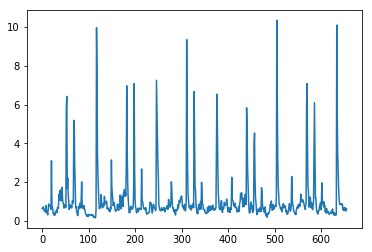

In [88]:
plt.plot(beats[44:])
plt.show()

In [89]:
#try with FFT now
# fft the sample
# calc total energy in each output "band" (32 results)
# shift the data into an energy array
num_bands = 32
band_size = int(beat_sample_size/num_bands)
ambient_array = np.ones((num_bands, 44))
beat_energy = np.ndarray(num_bands)
beat_ratio = np.ndarray(num_bands)
beats = np.ndarray((num_bands, 1))

for sample in range(samples):
    sample_start = data_start + sample * beat_sample_size
    
    data_to_fft = data[sample_start:(sample_start+beat_sample_size), 0]
#     print('data_to_fft')
#     print(data_to_fft)
    fft_result = np.fft.fft(data_to_fft)
#     print('fft_result')
#     print(fft_result)
    
    for band in range(num_bands):
        band_start = band * band_size
        beat_energy[band] = total_energy(fft_result[band_start:band_start + band_size])/band_size
#         print(beat_energy[band])
    
    beat_ratio = energy_ratio(beat_energy, ambient_array)
#     print('beat_ratio:')
#     print(beat_ratio)
#     print(beat_ratio.shape)
    
#     print('beats')
#     print(beats.shape)
    transposed_beat_ratio = beat_ratio.reshape(num_bands, 1)

    beats = np.append(beats, transposed_beat_ratio, axis=1)
#     print(beats)
#     print(beats.shape)
    
#     print('ambient_array')
#     print(ambient_array.shape)
#     print(beat_ratio.shape)
    
#     print('transposed_beat_ratio')
#     print(transposed_beat_ratio.shape)
    ambient_array = np.append(ambient_array[:,1:], transposed_beat_ratio, axis=1)
    
#     beat_ratio = energy_ratio(beat_energy, ambient_array)
#     beats = np.append(beats, beat_ratio)
#     ambient_array = np.append(ambient_array[1:], beat_energy)

#     print('ambient_array')
#     print(ambient_array)


ratio = sample_energy / ambient
[  4.76499994e+11   3.00355226e+10   1.01322733e+10   4.91121273e+09
   3.18129883e+09   3.10164191e+09   2.31871453e+09   7.48102677e+08
   8.13202004e+08   3.51098035e+08   4.56562057e+08   4.51477496e+07
   1.25187787e+07   1.15166230e+07   1.09845232e+07   1.07478830e+07
   1.07439719e+07   1.09700982e+07   1.14983937e+07   1.24746022e+07
   4.15259868e+07   4.55672886e+08   3.52812368e+08   7.76762534e+08
   7.61701142e+08   2.29326956e+09   3.14247935e+09   3.15880811e+09
   4.84574340e+09   7.62423403e+09   2.89624012e+10   4.79423003e+11] = [  4.76499994e+11   3.00355226e+10   1.01322733e+10   4.91121273e+09
   3.18129883e+09   3.10164191e+09   2.31871453e+09   7.48102677e+08
   8.13202004e+08   3.51098035e+08   4.56562057e+08   4.51477496e+07
   1.25187787e+07   1.15166230e+07   1.09845232e+07   1.07478830e+07
   1.07439719e+07   1.09700982e+07   1.14983937e+07   1.24746022e+07
   4.15259868e+07   4.55672886e+08   3.52812368e+08   7.76762534e+08

(32, 701)
(32,)
(701,)


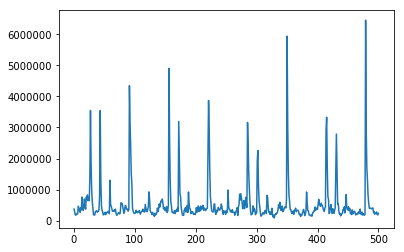

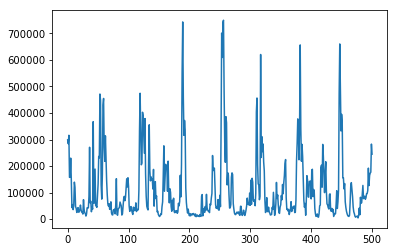

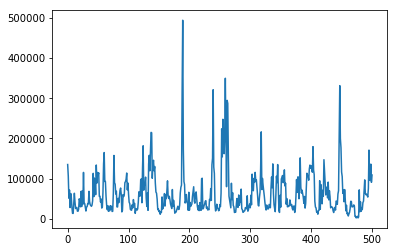

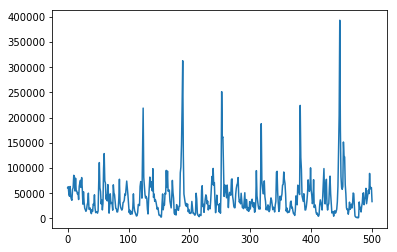

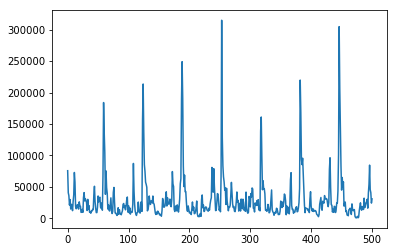

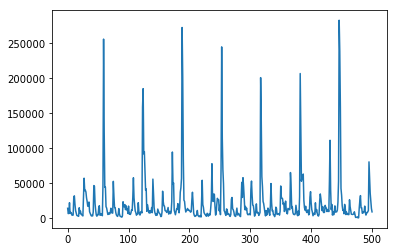

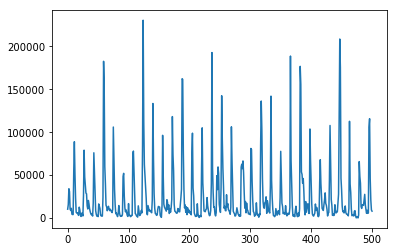

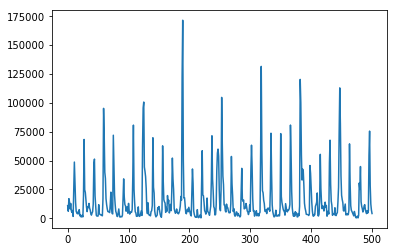

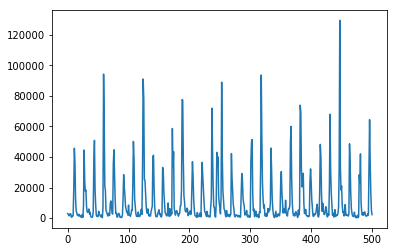

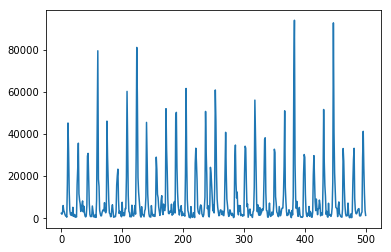

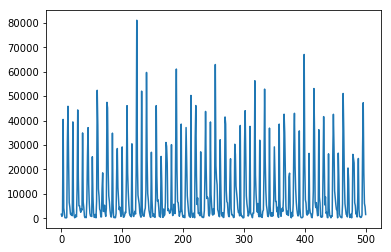

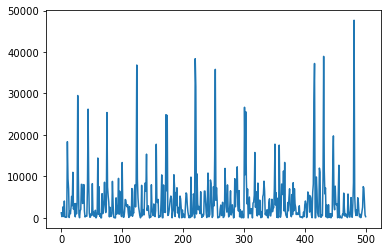

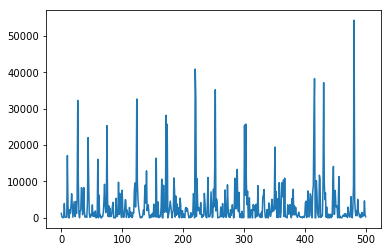

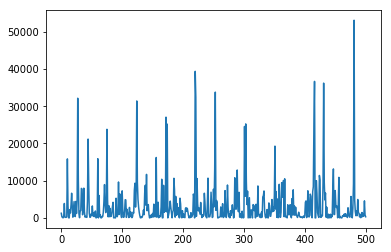

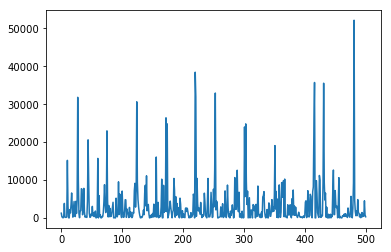

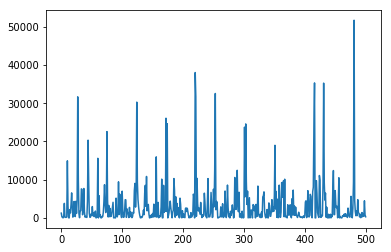

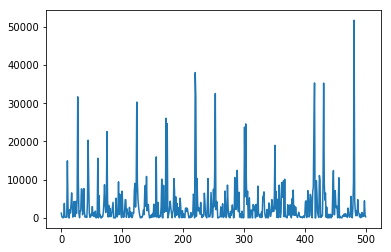

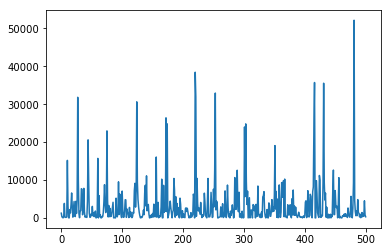

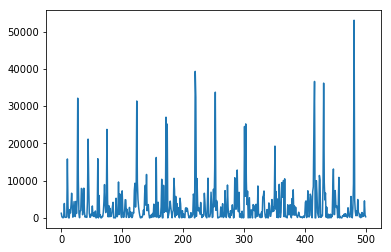

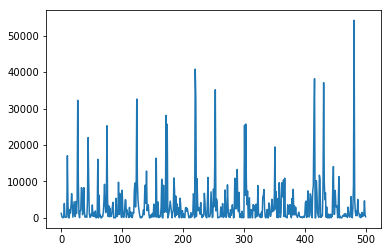

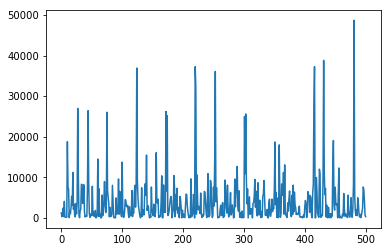

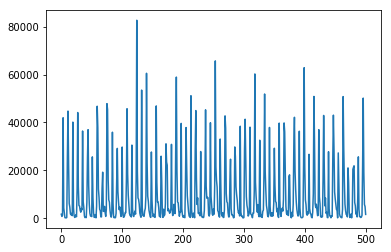

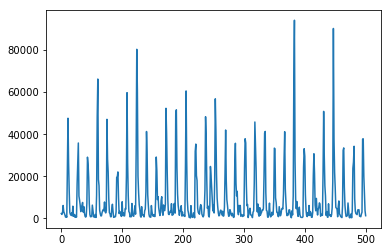

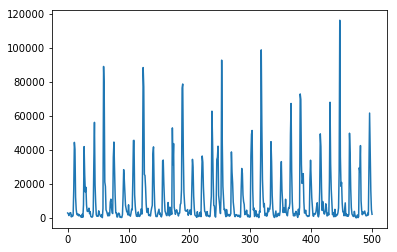

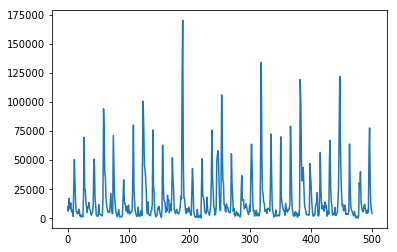

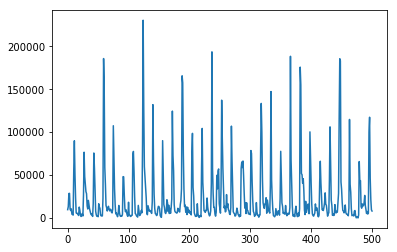

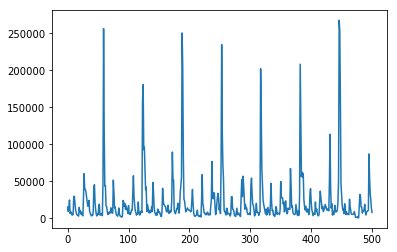

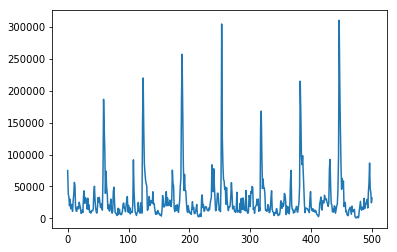

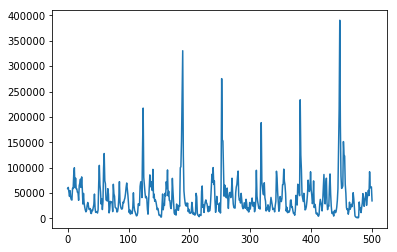

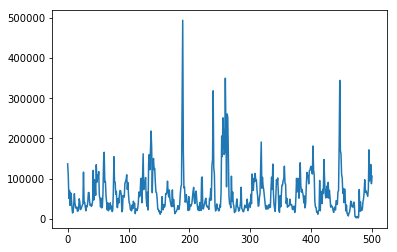

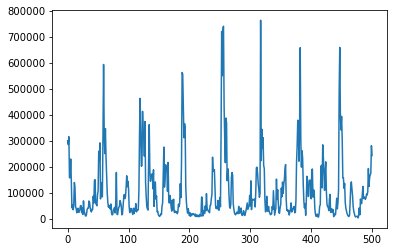

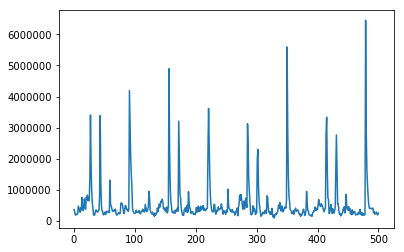

In [92]:
# print(beats)
print(beats.shape)
print(beats[:,1].shape)
print(beats[1,:].shape)
for band in range(int(num_bands)):
    plt.plot(beats[band,200:])
    plt.show()
    